# Introduction

This notebook describe the basic use of REAL toolbox.

## Requisites

- Numpy, Scipy, Matplotlib
- The lidar Toolbox.

## Resources

- [Numpy reference](https://numpy.org/doc/stable/reference/index.html).
- Matplotlib's [Pyplot functions](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.html) for a list of high-level plotting functions.

# Configuration

**/!\ Set the path** to the lidar Python toolbox below (`toolbox_dir` variable)

In [1]:
# Enable module autoreload
%load_ext autoreload
%autoreload 2

# Directories
toolbox_dir = '/Users/pderian/Documents/Xp/CanopyWave/canopywave/Ali_20190929'

# Python imports

In [2]:
# Standard
import sys  # System tools

# Third party (typically installed with Anaconda or pip)
import numpy as np  # Arrays and maths
import matplotlib.pyplot as plt  # Plotting functions
import scipy.interpolate as scinterp  # High-level interpolation

# Custom (e.g. REAL Toolbox)
sys.path.append(toolbox_dir)  # Here we add our directory to the system path so the modules can be found
import lidarIO.bscan as bscan  # lidarIO's bscan.py contains functions to read and preprocess bscans

# Read, preprocess and display a bscan

In [65]:
bscan_file = '/Users/pderian/Documents/Xp/CanopyWave/canopywave/resources/bscans/REAL.20070424_130105.bscan'

# Preprocessing parameters
lp_median = 7  # Size in [pixel] of low-pass median filter
hp_median = 333  # Size in [pixel] of high-pass median filter

# Read and preprocess scan data
scan_data = bscan.readPreprocScan(
    bscan_file,
    hpMedianFilter=hp_median,
    lpMedianFilter=lp_median,
    verbose=True,
    decimate=0,
    withSNR=False,
    withImgSNR=False,
)
print(f"\nscan_data contains the following entries:\n{list(scan_data.keys())}")

File /Users/pderian/Documents/Xp/CanopyWave/canopywave/resources/bscans/REAL.20070424_130105.bscan
	readRecordProperties=>100 records
	mapScans=>1 scans
	Reading scan #1 (100 records starting @0)

scan_data contains the following entries:
['x', 'y', 'azimuth', 'elevation', 'range', 'scan', 'time', 'label', 'snr', 'imgsnr']


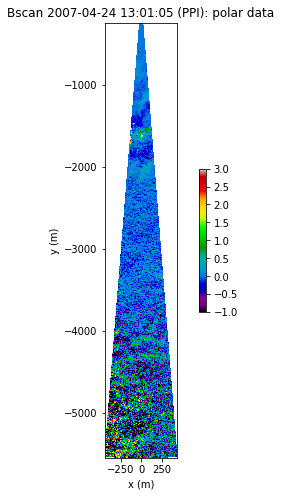

In [61]:
# Display
fig, axes = plt.subplots(figsize=(16, 8))
ax.set_title(f"Bscan {scan_data['time'][0]:%Y-%m-%d %H:%M:%S} ({scan_data['label']}): polar data")
ax.set_aspect('equal')  # Force same scale on x, y axes
plot_polar = ax.pcolormesh(
    scan_data['x'],
    scan_data['y'],
    scan_data['scan'],
    cmap='nipy_spectral',
    vmin=-1.,
    vmax=3.
)
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
plt.colorbar(plot_polar, shrink=.33)
plt.show()

# Grid the scan and display

Below is the entire process for gridding (interpolating) a scan.

The *grid* itself can be defined in many ways. The approach chosen here is a rather simple, where the user provides *resolution* and *bounds*. The latter are slightly adapted to make sure they are a multiple of the resolution. 

Then, the interpolation is done with a *nearest neighbor (NN) interpolator* as it deals with unstructured data quite efficiently. The original polar data is structured, but the "Sasano 1982" warp applied during wind motion estimation breaks the structure.

The one drawback with NN is that is becomes difficult to tell when grid points are outside the original scan domain, that is to say to *compute a domain mask*. A simple way to do so is to use another interpolator, linear this time, and supply a `fill_value`. It is however quite slow, so in practise a more efficient method is needed (e.g. for Canopy Waves).

See Scipy's [NearestNDInterpolator](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.NearestNDInterpolator.html) and [LinearNDInterpolator](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.LinearNDInterpolator.html) functions.

For 2D arrays, note that coordinate y is the first array dimension (rows) and x is the second (columns).

In [59]:
# Grid parameters
grid_xmin = -150.  # Lower x bound in [m]
grid_xmax = 150.  # Upper x bound in [m]
grid_ymin = -1800.  # Lower y bound in [m]
grid_ymax = -1400.  # Upper y bound in [m]
grid_resolution = 3.  # Grid step in [m / pixel]
print(f'Original bounds:\n\tx in [{grid_xmin}, {grid_xmax}] m\n\ty in [{grid_ymin}, {grid_ymax}] m')

# Adjust grid bounds to make sure they are a multiple of grid step
grid_xmin = grid_resolution * np.floor(grid_xmin / grid_resolution)
grid_xmax = grid_resolution * np.ceil(grid_xmax / grid_resolution)
grid_ymin = grid_resolution * np.floor(grid_ymin / grid_resolution)
grid_ymax = grid_resolution * np.ceil(grid_ymax / grid_resolution)
# Number of pixels
dim_x = int((grid_xmax - grid_xmin) / grid_resolution) + 1
dim_y = int((grid_ymax - grid_ymin) / grid_resolution) + 1
print(f'Revised bounds for {grid_resolution} m/px:\n\tx in [{grid_xmin}, {grid_xmax}] m ({dim_x} px)\n\ty in [{grid_ymin}, {grid_ymax}] m ({dim_y} px)')

# Generate grid coords (1d arrays)
grid_x = grid_resolution * np.arange(dim_x) + grid_xmin
grid_y = grid_resolution * np.arange(dim_y) + grid_ymin
np.set_printoptions(threshold=10)
print(f'Grid coords:\n\tx={grid_x} m\n\ty={grid_y} m')
grid_shape = [grid_y.size, grid_x.size]
print(f'Grid shape: {grid_shape} pixel (1st dim is y, 2nd is x)')

# Generate grid mesh (2D arrays)
grid_xx, grid_yy = np.meshgrid(grid_x, grid_y)
# Gather coords as a (N, 2) array of coords [[x0, y0], [x1, y1], ...]
raw_yyxx = np.concatenate((scan_data['y'].reshape((-1,1)), scan_data['x'].reshape((-1,1))), axis=1)
grid_yyxx = np.concatenate((grid_yy.reshape((-1,1)), grid_xx.reshape((-1,1))), axis=1)

# Interpolate on the gridded scan
# Here we use scipy's nearest neighbor interpolation for the scan
nn_interpolator = scinterp.NearestNDInterpolator(raw_yyxx, scan_data['scan'].ravel())
grid_scan = nn_interpolator(grid_yyxx).reshape(grid_shape)
print(f'Gridded scan shape: {grid_scan.shape}')
# And we use scipy's linear ND interpolator to compute a mask: data are 1s, out of domain are set to 0s.
lin_interpolator = scinterp.LinearNDInterpolator(raw_yyxx, np.ones(raw_yyxx.shape[0]), fill_value=0.)
grid_mask = lin_interpolator(grid_yyxx).reshape(grid_shape) > 0  # Apply threshold here to get a binary array
print(f'Scan mask shape: {grid_mask.shape}')


Original bounds:
	x in [-150.0, 150.0] m
	y in [-1800.0, -1400.0] m
Revised bounds for 3.0 m/px:
	x in [-150.0, 150.0] m (101 px)
	y in [-1800.0, -1398.0] m (135 px)
Grid coords:
	x=[-150. -147. -144. ...,  144.  147.  150.] m
	y=[-1800. -1797. -1794. ..., -1404. -1401. -1398.] m
Grid shape: [135, 101] pixel (1st dim is y, 2nd is x)
Gridded scan shape: (135, 101)
Scan mask shape: (135, 101)


Next, we display the gridded scan next to the original one in polar coordinates. For gridded data (akin to images) we use Matplotlib's [imshow()](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.imshow.html), and we use a [masked array](https://numpy.org/doc/stable/reference/maskedarray.generic.html) to discard out-of-scan points. Note that, for masked arrays the mask is "reverse", i.e. `True` where points should be masked. Thus we take the logical NOT of the domain mask previously computed. 

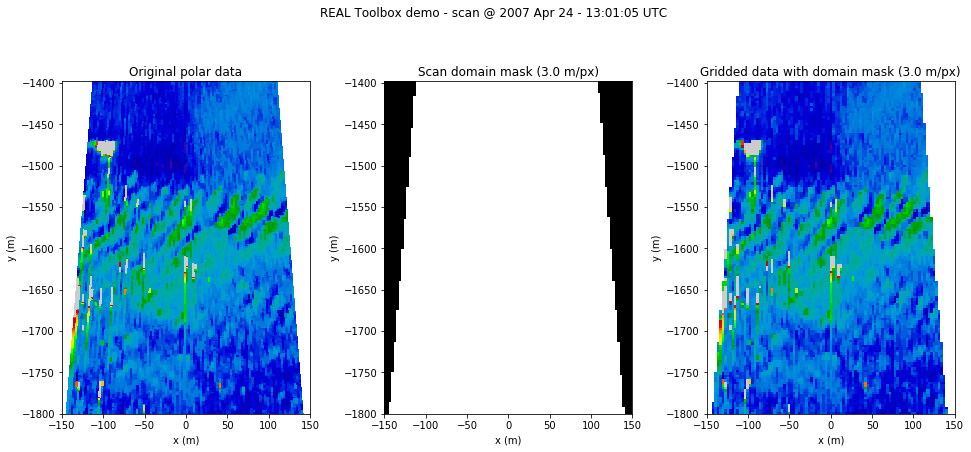

In [60]:
# Create figure, here with 3 axes
fig, axes = plt.subplots(1, 3, figsize=(16, 7))
axp, axm, axs = axes  # Polar, Mask, Scan
# Polar data
axp.set_title('Original polar data')
axp.set_aspect('equal')  # Force same scale on x, y axes
p0 = axp.pcolormesh(
    scan_data['x'],
    scan_data['y'],
    scan_data['scan'],
    cmap='nipy_spectral',
    vmin=-1,
    vmax=3
    )
# Gridded domain mask
axm.set_title(f"Scan domain mask ({grid_resolution} m/px)")
p1 = axm.imshow(
    grid_mask,
    interpolation='nearest',
    cmap='gray',
    vmin=0,
    vmax=1,
    origin='bottom',
    extent=[grid_xmin, grid_xmax, grid_ymin, grid_ymax],
    )
# Gridded scan with domain mask
axs.set_title(f"Gridded data with domain mask ({grid_resolution} m/px)")
p2 = axs.imshow(
    np.ma.array(grid_scan, mask=np.logical_not(grid_mask)),
    interpolation='nearest',
    cmap='nipy_spectral',
    vmin=-1.,
    vmax=3.,
    origin='bottom',
    extent=[grid_xmin, grid_xmax, grid_ymin, grid_ymax],
    )
# Tune axes
for ax in axes:
    # Set plot limits to grid bounds
    ax.set_xlim(xmin=grid_xmin, xmax=grid_xmax)
    ax.set_ylim(ymin=grid_ymin, ymax=grid_ymax)
    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')
# Add global title
plt.figtext(
    0.5,
    0.98,
    f"REAL Toolbox demo - scan @ {scan_data['time'][0]:%Y %b %d - %H:%M:%S} UTC",
    ha='center',
    va='top',
    size='large',
    )
# Make room in between axes for labels
fig.subplots_adjust(wspace=0.3)
# And save the figure BEFORE displaying it
fig.savefig("bscan_compare.png")
plt.show()
